# Hand Gesture Recognition Using Deep Learning


## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Each video is a sequence of 30 frames (or images).

##Objectives:

1. Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

To initiate the model building process, the first step is to obtain the dataset and store it locally. This can be accomplished by following the provided steps:

1. Open the terminal.
2. Go to following link: `https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL`
3. Unzip the downloaded file named 'Project_data.zip'.

### 1. Importing the libraries

In [ ]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import skimage
from skimage.transform import resize
import datetime
import cv2
import abc
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import  Conv3D, Conv2D,  MaxPooling3D, MaxPooling2D, Dropout
from keras.applications import mobilenet
import tensorflow as tf
import random as rn
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.16.1
3.1.1


In [ ]:
# Setting the random state to replicate the output
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [ ]:
from zipfile import ZipFile
with ZipFile('./Project_data.zip','r') as zip:
  zip.extractall('/tmp')

In [ ]:
# Add the root folder name as base path
base_path = '/tmp/Project_data'

### Solution Overview

We will be using Convolutional Neural Network (CNN) combined with Recurrent Neural Network (RNN) architecture.
In this architecture, the Conv2D network extracts a feature vector for each image, and subsequently, a sequence of these feature vectors is inputted into an RNN-based network. The output of the RNN is a conventional softmax.

The other popular architecture used to process videos is a natural extension of CNNs - a 3D convolutional network. In this project, you will try both these architectures.

We'll establish a class `ModelBuilder` that serves as an abstract foundation for constructing models and data generators tailored for gesture recognition in smart TVs. This class encompasses functionalities for setting up paths, image properties, hyperparameters, and generating training data batches. Furthermore, it incorporates a method for model training and an abstract method for specifying the model architecture.

In [ ]:
class ModelBuilder(metaclass=abc.ABCMeta):
    """
    Abstract base class for building models and data generators.
    """

    def initialize_path(self, base_path):
        """
        Initialize paths for training and validation data.

        Args:
        - base_path (str): Base directory path containing train.csv and val.csv.

        Returns:
        - None
        """
        self.train_doc = np.random.permutation(open(base_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(base_path + '/' + 'val.csv').readlines())
        self.train_path = base_path + '/' + 'train'
        self.val_path = base_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_props(self, image_height=100, image_width=100):
        """
        Initialize properties related to images.

        Args:
        - image_height (int): Height of the images.
        - image_width (int): Width of the images.

        Returns:
        - None
        """
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):
        """
        Initialize hyperparameters for training.

        Args:
        - number_of_sample_frames (int): Number of sample frames.
        - batch_size (int): Batch size for training.
        - num_epochs (int): Number of epochs for training.

        Returns:
        - None
        """
        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs


    def generator(self, source_path, folder_list, augment=False):
        """
        Generator function for creating batches of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - folder_list (list): List of folders containing video frames.
        - augment (bool): Whether to perform data augmentation.

        Yields:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int)) #np.arange(0, self.total_frames, 2)
        batch_size = self.batch_size

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_samples = len(t) % batch_size

            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):
        """
        Fetch one batch of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - t (list): List of folders containing video frames.
        - batch (int): Batch index.
        - batch_size (int): Batch size.
        - img_idx (numpy array): Indices of frames to be considered.
        - augment (bool): Whether to perform data augmentation.
        - remaining_samples (int): Number of remaining samples in the last batch.

        Returns:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """

        seq_length = remaining_samples if remaining_samples else batch_size

        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_length, self.num_classes))

        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))


        for folder in range(seq_length):
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))


                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])


        return(batch_data, batch_labels)


    def train_model(self, model, augment_data=False):
        """
        Train the model.

        Args:
        - model: Model to be trained.
        - augment_data (bool): Whether to augment the training data.

        Returns:
        - history: Training history.
        """
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def model_definition(self):
        """
        Abstract method for defining the model architecture.
        """
        pass


### Visualization of Training and Validation Metrics

This can be achieved by utilizing the `plot` function, which generates visualizations for the training and validation loss, as well as `categorical accuracy` and `validation categorical accuracy`. It relies on the training metrics stored in the history object returned by `model.fit()`. The resulting plot includes two subplots, each displaying the trend of a specific metric across epochs.

In [ ]:
def plot(history):
    """
    Plots training and validation loss, as well as categorical accuracy and validation categorical accuracy.

    Args:
    - history: History object returned by model.fit(), containing training metrics.

    Returns:
    - None
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

## Model 1 - Conv3D

In [ ]:
class ModelConv3D(ModelBuilder):

    def model_definition(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.number_of_sample_frames,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1 = ModelConv3D()
conv_3d1.initialize_path(base_path)
conv_3d1.initialize_image_props(image_height=120, image_width=120)
conv_3d1.initialize_hyperparameters(number_of_sample_frames=16, batch_size=10, num_epochs=20)
conv_3d1_model = conv_3d1.model_definition(dense_neurons=64, dropout=0.25)
conv_3d1_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_18 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_18 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_19 (Conv3D)                   │ (None, 2, 15, 15, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [ ]:
print("Total Parameters: ", conv_3d1_model.count_params())
model_1 = conv_3d1.train_model(conv_3d1_model, augment_data=True)

Total Parameters:  504709
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2785 - loss: 2.1036
Epoch 1: saving model to model_init_2024-04-2809_34_55.023451/model-00001-1.78221-0.36124-2.77486-0.25000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - categorical_accuracy: 0.2797 - loss: 2.0989 - val_categorical_accuracy: 0.2500 - val_loss: 2.7749 - learning_rate: 2.0000e-04
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5222 - loss: 1.2184
Epoch 2: saving model to model_init_2024-04-2809_34_55.023451/model-00002-1.20820-0.51961-4.22959-0.14000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - categorical_accuracy: 0.5222 - loss: 1.2182 - val_categorical_accuracy: 0.1400 - val_loss: 4.2296 - learning_rate: 2.0000e-04
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6017 - loss: 1.0124
Epoch 3: saving model to model_init_2024-04-2809_34_55.023451/model-00003-0.97941-0.62519-4.77772-0.20000.keras
67/67 ━━━━━━━━━━━

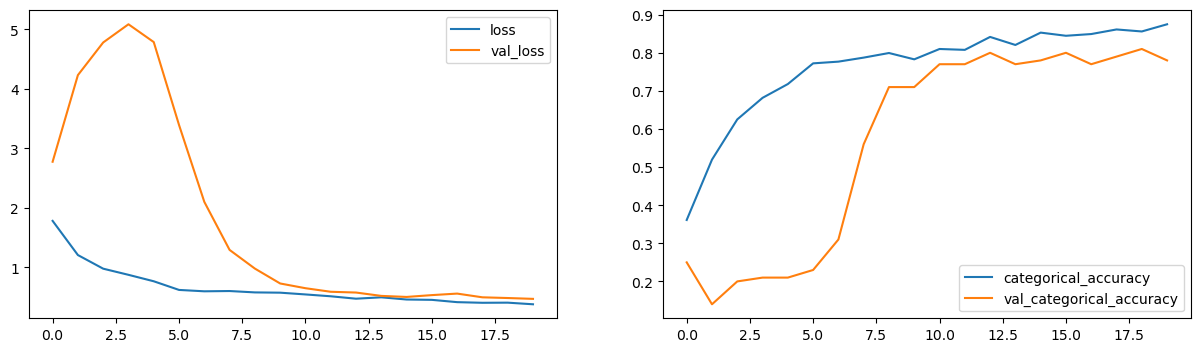

In [ ]:
plot(model_1)

***Observations:***

We used a Conv3D setup to train on 16 frames from the video. Our training accuracy hit 87%, but validation only reached 78%, suggesting overfitting might be happening. To address this concern, we aim to experiment with an alternative architecture, combining CNN with LSTM.

## Model 2 - CNN with LSTM

In [ ]:
class RNNCNN1(ModelBuilder):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = keras.optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_1 = RNNCNN1()
rnn_cnn_1.initialize_path(base_path)
rnn_cnn_1.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_1.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_1 = rnn_cnn_1.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_93                  │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_94                  │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_95                  │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_96                  │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_97                  │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_98                  │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_99                  │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_100                 │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_101                 │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_102                 │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_103                 │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_104                 │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_105                 │ (None, 18, 7, 7, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_106                 │ (None, 18, 7, 7, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
print("Total Parameters: ", rnn_cnn_model_1.count_params())
model_2 = rnn_cnn_1.train_model(rnn_cnn_model_1, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.3062 - loss: 1.5158 
Epoch 1: saving model to model_init_2024-04-2806_22_45.094910/model-00001-1.39996-0.38386-1.19611-0.50000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 419s 11s/step - categorical_accuracy: 0.3084 - loss: 1.5125 - val_categorical_accuracy: 0.5000 - val_loss: 1.1961 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.5428 - loss: 1.1102
Epoch 2: saving model to model_init_2024-04-2806_22_45.094910/model-00002-1.03857-0.58824-0.81115-0.72000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 300s 9s/step - categorical_accuracy: 0.5441 - loss: 1.1082 - val_categorical_accuracy: 0.7200 - val_loss: 0.8112 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.6533 - loss: 0.9068
Epoch 3: saving model to model_init_2024-04-2806_22_45.094910/model-00003-0.86244-0.67421-0.75461-0.74000.keras
34/34 ━━━━━━━━━━━━━━━

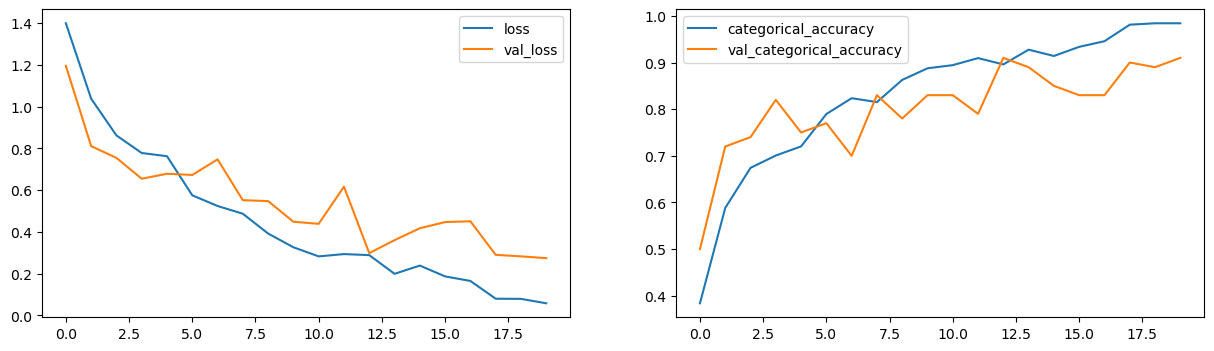

In [ ]:
plot(model_2)

***Observations:***

The training accuracy demonstrates consistent improvement, achieving 98%, while the validation accuracy reaches a maximum of 90%, continuing to indicate potential overfitting. To address this concern, we aim to experiment with an alternative architecture, combining CNN with GRU, while maintaining the same number of frames.

## Model 3 - CNN with GRU

In [ ]:
class RNNCNN2(ModelBuilder):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_2 = RNNCNN2()
rnn_cnn_2.initialize_path(base_path)
rnn_cnn_2.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_2.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_2 = rnn_cnn_2.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_109                 │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_110                 │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_111                 │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_112                 │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_113                 │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_114                 │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_115                 │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_116                 │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_117                 │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_118                 │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_119                 │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_120                 │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_121                 │ (None, 18, 6272)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │       2,458,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │              

 Total params: 2,573,925 (9.82 MB)

 Trainable params: 2,573,445 (9.82 MB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
print("Total Parameters: ", rnn_cnn_model_2.count_params())
model_3 = rnn_cnn_2.train_model(rnn_cnn_model_2, augment_data=True)

Total Parameters:  2573925
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3434 - loss: 1.5288
Epoch 1: saving model to model_init_2024-04-2808_01_23.643362/model-00001-1.33162-0.44042-1.12960-0.53000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 324s 9s/step - categorical_accuracy: 0.3461 - loss: 1.5232 - val_categorical_accuracy: 0.5300 - val_loss: 1.1296 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.6762 - loss: 0.8876
Epoch 2: saving model to model_init_2024-04-2808_01_23.643362/model-00002-0.82462-0.70513-0.71064-0.72000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step - categorical_accuracy: 0.6770 - loss: 0.8858 - val_categorical_accuracy: 0.7200 - val_loss: 0.7106 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.7873 - loss: 0.6174
Epoch 3: saving model to model_init_2024-04-2808_01_23.643362/model-00003-0.61764-0.78130-0.67527-0.72000.keras
34/34 ━━━━━━━━━━

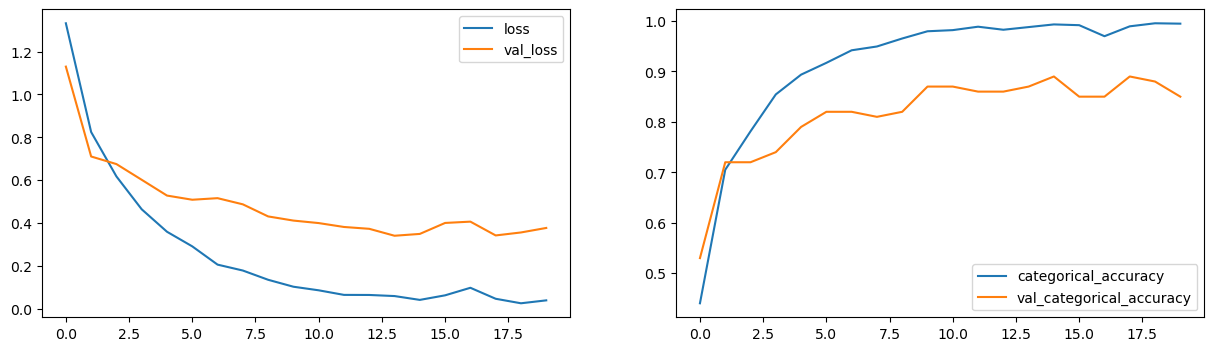

In [ ]:
plot(model_3)

***Observations:***

By incorporating GRU-RNN, there is a marginal increase in training accuracy, reaching 99%, whereas the validation accuracy significantly decreased to 85%, indicating overfitting.

## Model 4 - CNN with GRU (with trainable weights of Transfer Learning)

In [ ]:
class RNNCNN_TL_GRU(ModelBuilder):

    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimizer =  keras.optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_4 = RNNCNN_TL_GRU()
rnn_cnn_4.initialize_path(base_path)
rnn_cnn_4.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_4.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_4 = rnn_cnn_4.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_12                  │ ?                           │       3,228,864 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
print("Total Parameters: ", rnn_cnn_model_4.count_params())
model_4 = rnn_cnn_4.train_model(rnn_cnn_model_4, augment_data=True)

Total Parameters:  3228864
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3398 - loss: 1.5397
Epoch 1: saving model to model_init_2024-04-2811_33_45.378766/model-00001-1.26966-0.47511-0.56812-0.81000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - categorical_accuracy: 0.3408 - loss: 1.5377 - val_categorical_accuracy: 0.8100 - val_loss: 0.5681 - learning_rate: 2.0000e-04
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7691 - loss: 0.6457
Epoch 2: saving model to model_init_2024-04-2811_33_45.378766/model-00002-0.60903-0.77753-0.32649-0.89000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - categorical_accuracy: 0.7691 - loss: 0.6455 - val_categorical_accuracy: 0.8900 - val_loss: 0.3265 - learning_rate: 2.0000e-04
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8516 - loss: 0.3931
Epoch 3: saving model to model_init_2024-04-2811_33_45.378766/model-00003-0.37860-0.86199-0.32429-0.87000.keras
133/13

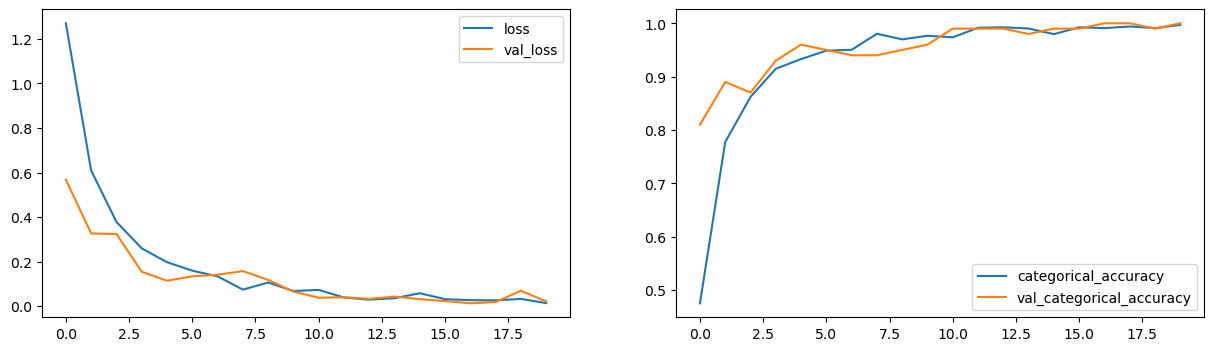

In [ ]:
plot(model_4)

***Observations:***

Using GRU and transfer learning with pre-trained weights, we see a significant jump in training accuracy to 99% and validation accuracy to 99%. This shows we've effectively tackled overfitting, and the model performs strongly on the validation set. So, we can consider this our final model for evaluation.

**Awesome results! 99% Training accuracy and 99% validation accuracy**

## Model Evaluation

In [ ]:
from keras.models import load_model
model = load_model('/Users/vmanupam/Downloads/model-00020-0.01408-0.99698-0.02186-1.00000.keras')

In [ ]:
test_generator = RNNCNN_TL_GRU()
test_generator.initialize_path(base_path)
test_generator.initialize_image_props(image_height=120, image_width=120)
test_generator.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=False)
batch_data, batch_labels = next(g)

In [ ]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:, :, :, :, :]), axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
[3 0 4 2 3]
